In [1]:
import numpy as np
from astropy.io import fits
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
import photutils
from scipy.stats import poisson
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from collections import Counter
import pandas as pd

from scipy.optimize import curve_fit

In [2]:
#Plot formatting
font = {'size':16, 'family':'serif'}

matplotlib.rc('font', **font)

Repeating fast radio burst (FRB) source 20220912A (called “R117” internally) was discovered by the
CHIME/FRB experiment to be highly active late last year (https://www.astronomerstelegram.org/?read=15679) and has subsequently been detected by a variety
of other telescopes as well. The source remains active today. 

The goal of this project is to characterize the source’s activity as a function of time. 


Success!:

In [3]:
# Load the NPZ file
data = np.load("R117_allevents_20230420.npz")

# Extract the timestamps from the 'timestamp.npy' key
timestamps = data["timestamp.npy"]

# Convert the timestamps to strings and remove the time zone offset
time_stamps = [ts.astype(str).replace(' UTC+0000', '') for ts in timestamps]


In [4]:
time_dates = [datetime.strptime(i[:-7], '%Y-%m-%d %H:%M:%S').date() for i in time_stamps]

In [5]:
# Extract the 'event_no' values from the header
event_ids = data['event_no.npy']
event_ids = [str(ts) for ts in event_ids]

1. Burst rates as a function of time

1. 1 Produce a plot showing all detections as a function of time.

C:\Users\12504\AppData\Local\Temp\ipykernel_9640\1331221031.py:26: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=9)


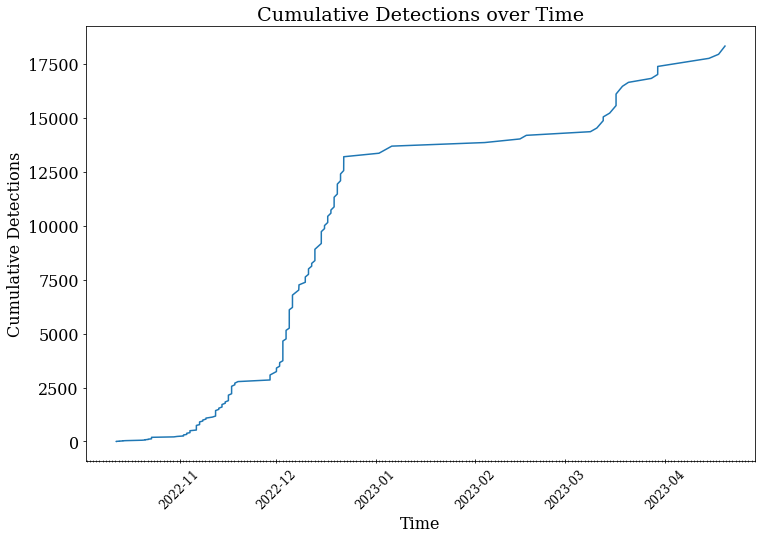

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cumulative_detections(detections):
    # Sort the detections by time
    detections = sorted(detections)

    # Convert the string timestamps to datetime objects
    timestamps = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f') for ts in detections]

    # Initialize the accumulator
    cumulative_counts = [0]

    # Accumulate the detections
    for i in range(1, len(timestamps)):
        cumulative_counts.append(cumulative_counts[i-1] + i)

    # Increase the figure size
    plt.figure(figsize=(12, 8))  
    
    # Plot the cumulative detections
    plt.plot(timestamps, cumulative_counts)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Detections')
    plt.title('Cumulative Detections over Time')
    plt.locator_params(axis='x', nbins=9)
    # Increase the number of ticks in between the x-axis labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    # Add x-axis ticks on the top axis
    ax.tick_params(axis='x', which='both', direction='inout')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=12)
    
    plt.savefig('cumulative.pdf', bbox_inches='tight')
    plt.show()
    

# Call the function to plot the cumulative detections
plot_cumulative_detections(time_stamps)


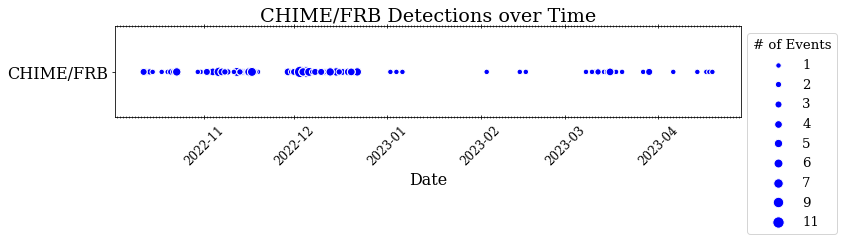

In [7]:
# Convert date objects to datetime objects
time_stamps = [datetime.combine(date, datetime.min.time()) for date in time_dates]

# Count the occurrences per day
occurrences_per_day = Counter(time_stamps)

# Get the sizes of markers based on occurrences
marker_sizes = [20 + 10 * occurrences_per_day[ts] for ts in time_stamps]

# Create a constant array for the y-axis
y = [1] * len(time_dates)

# Increase the figure size
plt.figure(figsize=(12, 3))

# Plot the timestamps on the x-axis and the constant on the y-axis with varying marker sizes
plt.scatter(time_stamps, y, s=marker_sizes, marker='o', facecolor='blue', edgecolor='white', alpha=1)

# Set the x-axis format as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set the y-axis tick to 1
plt.yticks([1], ['CHIME/FRB'])

plt.xlabel('Date')
plt.title('CHIME/FRB Detections over Time')

# Increase the number of ticks in between the x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(MultipleLocator(1))

# Add x-axis ticks on the top axis
ax.tick_params(axis='x', which='both', direction='inout', top=True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add a legend for the size of markers
sizes = [30, 40, 50, 60, 70, 80, 90, 110, 130]  # Replace with your actual size values
legend_labels = ['1', '2', '3', '4', '5', '6', '7', '9', '11']  # Replace with your actual legend labels
legend_markers = [plt.scatter([], [], s=size, marker='o', facecolor='blue', edgecolor='white', alpha=1) for size in sizes]
legend = plt.legend(legend_markers, legend_labels, title='# of Events', loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
legend.set_title('# of Events', prop={'size': 'small'})

plt.tight_layout()
# Save the plot before displaying
plt.savefig('timeline.pdf', bbox_inches='tight')
# Show the plot
plt.show()


1.2 Produce a histogram showing the number of detections per day.

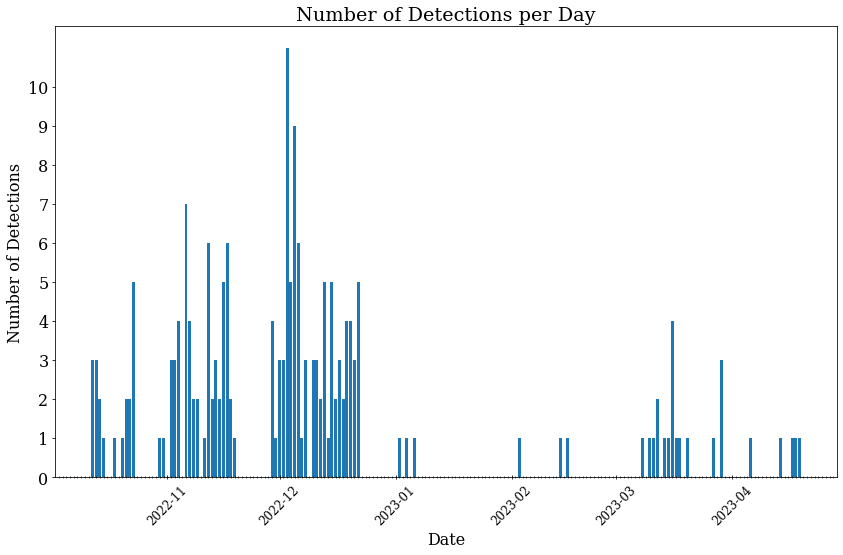

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences of each date
date_counts = Counter(time_dates)

# Extract dates and counts
dates = list(date_counts.keys())
counts = list(date_counts.values())

# Create histogram
plt.figure(figsize=(12, 8))
plt.bar(dates, counts)


# Customize the plot
plt.xlabel('Date')
plt.ylabel('Number of Detections')
plt.title('Number of Detections per Day')
plt.yticks(range(11))  # Set the y-axis tick values from 0 to 10

# Increase the number of ticks in between the x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(MultipleLocator(1))
# Add x-axis ticks on the top axis
ax.tick_params(axis='x', which='both', direction='inout')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.savefig('histogram.pdf', bbox_inches='tight')

# Display the plot
plt.show()



1.3 Assuming a uniform observation duration (also called “exposure”) on each day, measure a
    “Poisson” burst rate for the source over the total duration for which we have detections and for
    each individual day (rate = # of detections / exposure time). Include Poisson errors on your
    counting experiment (hint: use the scipy.stats.poisson.interval function for this; for now you can
    look at, say, 90% confidence intervals, but this should be easy to tweak later).


In [9]:
#SUCCESS YAYYYYYY

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
###This gives poisson burst rate per min
def calculate_poisson_burst_rate(observations):
    daily_rates = []
    unique_dates = []  # Store unique dates
    lower_bounds = []  # Store lower bounds of confidence intervals
    upper_bounds = []  # Store upper bounds of confidence intervals
    
    # Count occurrences of each date
    date_counts = Counter(observations)

    # Loop through the unique dates
    for date in date_counts.keys():
        # Get the count for the current date
        count = date_counts[date]
        # Assume a daily exposure of 5.6 min
        daily_rate = count / 5.6
        daily_rates.append(daily_rate)
        unique_dates.append(date)  # Store the unique date
        
        print(f"\n{date} Burst Rate:")
        print(f"Number of Detections: {count}")
        print(f"Burst Rate per day: {daily_rate} bursts/min")

        # Calculate Poisson error bars on daily rate
        confidence = 0.9  # 90% confidence interval
        lower_bound_daily, upper_bound_daily = poisson.interval(confidence, count, loc=0)
        lower_bound_daily /= 5.6  # Adjust the lower bound to per day rate
        upper_bound_daily /= 5.6  # Adjust the upper bound to per day rate
        lower_bounds.append(lower_bound_daily)
        upper_bounds.append(upper_bound_daily)
        
        print(f"Confidence Interval on burst rate per min: [{lower_bound_daily}, {upper_bound_daily}]")
    
    return daily_rates, unique_dates, lower_bounds, upper_bounds

daily_rates, unique_dates, lower_bounds, upper_bounds = calculate_poisson_burst_rate(time_dates)

# Calculate burst rate for the total duration
total_detections = len(time_dates)
total_rate = total_detections / (5.6*len(unique_dates))
    
confidence = 0.9
lower_bound, upper_bound = poisson.interval(confidence, total_rate)
print(f"\nTotal Burst Rate:")
print(f"Total Detections: {total_detections}")
print(f"Total Duration: {5.6*len(unique_dates)}")
print(f"Burst Rate: {total_rate} bursts/min")
print(f"Confidence Interval on total burst rate: [{lower_bound/5.6}, {upper_bound/5.6}]")

#This gives the exposure time for all detections whether they are in fwhm with 0 exposure time or in sidelobes

lower, upper = poisson.interval(confidence, (0/5.6))
print(f"Confidence Interval on total burst rate: [{lower}, {upper}]")



2023-02-14 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.17857142857142858 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.5357142857142857]

2023-02-16 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.17857142857142858 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.5357142857142857]

2023-03-08 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.17857142857142858 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.5357142857142857]

2023-03-11 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.17857142857142858 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.5357142857142857]

2023-03-12 Burst Rate:
Number of Detections: 2
Burst Rate per day: 0.35714285714285715 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.8928571428571429]

2023-03-14 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.17857142857142858 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.5357142857

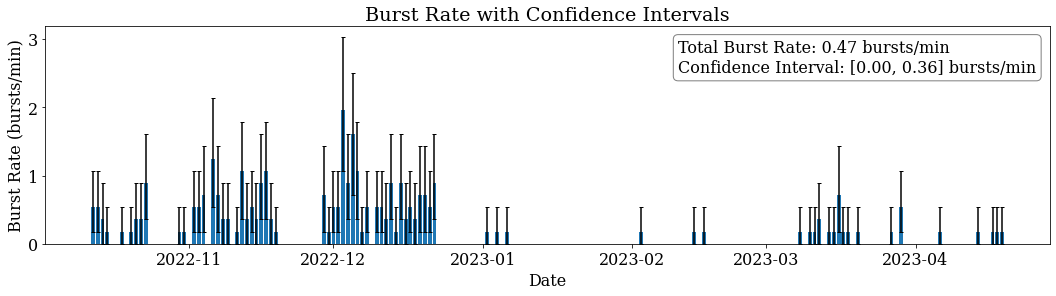

In [10]:
# Plotting
plt.figure(figsize=(18, 4))
x = np.array(unique_dates)
y = np.array(daily_rates)
y_error = np.array([y - lower_bounds, upper_bounds - y])
plt.bar(x, y, yerr=y_error, capsize=2)


plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rate with Confidence Intervals')

# Create a box in the top right corner with mean burst rate and confidence interval information
text_box = f"Total Burst Rate: {total_rate:.2f} bursts/min\n"
text_box += f"Confidence Interval: [{lower_bound/5.6:.2f}, {upper_bound/5.6:.2f}] bursts/min"


plt.text(0.63, 0.79, text_box, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Burst_Rates_with_Confidence_Intervals.pdf', bbox_inches='tight')
plt.show()



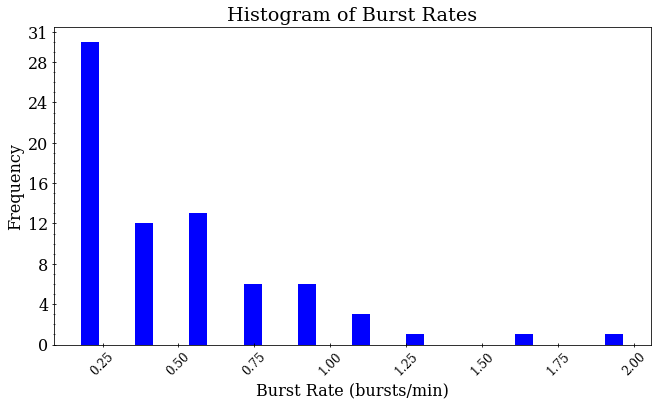

In [11]:
# Plot histogram
plt.figure(figsize=(10, 6))


# Set the x-axis label and rotate the x-axis tick labels for better readability
plt.xlabel('Burst Rate (bursts/min)')
plt.ylabel('Frequency')
plt.title('Histogram of Burst Rates')

# Increase the number of ticks in between the x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(MultipleLocator(1))
# Add x-axis ticks on the top axis
ax.tick_params(axis='x', which='both', direction='inout')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Increase the number of ticks in between the x-axis labels
ax = plt.gca()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_minor_locator(MultipleLocator(1))
# Add x-axis ticks on the top axis
ax.tick_params(axis='y', which='both', direction='inout')

plt.tight_layout()
plt.savefig('histogram_bursts.pdf')

plt.hist(daily_rates, bins=30, color='blue')
# Display the histogram
plt.show()

#The plot shows a histogram of the burst rates (daily_rates) over the unique dates. Each bar in the histogram represents a range of burst rates, and the height of each bar represents the frequency of occurrence of burst rates within that range.

# By visualizing the burst rates in a histogram, you can gain insights into the distribution of burst rates across the unique dates. It provides an overview of the frequency or count of burst rates within different ranges, allowing you to identify any patterns or outliers in the data.

# Analyzing the histogram can help you understand the distribution of burst rates, such as whether they are concentrated around a specific range or if there are variations across the unique dates. It can also provide insights into the overall shape of the distribution, including whether it is skewed, symmetric, or multimodal.

# The histogram allows you to explore the burst rate data in a visual manner, facilitating the identification of trends, patterns, and potential anomalies.#

In [12]:
# Stack the unique_dates and daily_rates arrays
stacked_data = np.column_stack((unique_dates, daily_rates))

# Sort the stacked data by date
sorted_data = stacked_data[np.argsort(stacked_data[:, 0])]

# Extract the sorted unique_dates and daily_rates arrays
sorted_dates = sorted_data[:, 0]
sorted_rates = sorted_data[:, 1]

# Convert sorted_dates to matplotlib.dates.date2num format
sorted_dates = mdates.date2num(sorted_dates)

sorted_dates = sorted_dates.astype(float)
sorted_rates = sorted_rates.astype(float)

## Create a step plot
#plt.figure(figsize=(12, 4))

#plt.fill_between(sorted_dates, sorted_rates, color='red', step='pre', alpha=0.2)
#plt.plot(sorted_dates, sorted_rates, color='red', drawstyle="steps", marker='|')


# # Set the x-axis label and rotate the x-axis tick labels for better readability
# plt.xlabel('Date')
# plt.ylabel('Burst Rate (bursts/min)')
# plt.title('Burst Rates over Time')

# # Format the x-axis tick labels as "YYYY-MM"
# date_formatter = mdates.DateFormatter('%Y-%m')
# plt.gca().xaxis.set_major_formatter(date_formatter)

# # Rotate the x-axis labels for better readability
# plt.xticks(rotation=45, fontsize=12)

# plt.tight_layout()
# #plt.savefig('Burst_Rates_over_Time.png')
# # Display the plot
# plt.show()


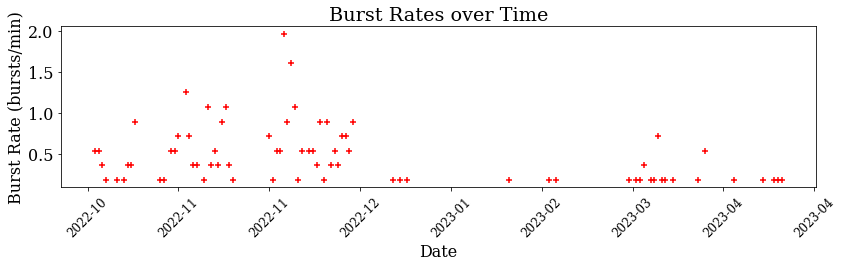

In [13]:
# Create a scatter plot
plt.figure(figsize=(12, 4))

plt.scatter(sorted_dates, sorted_rates, color='red', marker='+')

# Set the x-axis label and rotate the x-axis tick labels for better readability
plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rates over Time')

# Format the x-axis tick labels as "YYYY-MM"
date_formatter = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_formatter)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.savefig('Burst_Rates_over_Time.pdf')
# Display the plot
plt.show()


In [14]:
rate_list = []

for date in time_dates:
    matching_row = np.where(sorted_data[:, 0] == date)[0]
    if len(matching_row) > 0:
        rate = sorted_data[matching_row[0], 1]
        rate_list.append([date, rate])
    else:
        rate_list.append([date, None])

len(rate_list)

# Convert rate_list to a NumPy array
rate_list = np.array(rate_list)

In [15]:
# Sort the stacked data by date
sorted_rate_list = rate_list[np.argsort(rate_list[:, 0])]

# Extract the sorted unique_dates and daily_rates arrays
sorted_rate_list_date = sorted_rate_list[:, 0]
sorted_rate_list_rate = sorted_rate_list[:, 1]

# Convert sorted_dates to matplotlib.dates.date2num format
sorted_rate_list_date = mdates.date2num(sorted_rate_list_date)

sorted_rate_list_date = sorted_rate_list_date.astype(float)
sorted_rate_list_rate = sorted_rate_list_rate.astype(float)



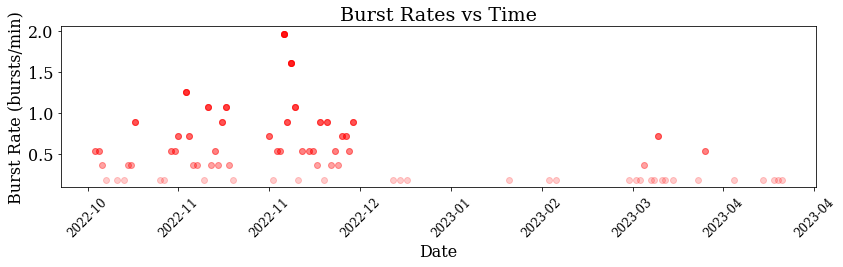

In [16]:
# Create a scatter plot
plt.figure(figsize=(12, 4))

plt.scatter(sorted_rate_list_date,sorted_rate_list_rate, color='red', alpha=0.2)


# Set the x-axis label and rotate the x-axis tick labels for better readability
plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rates vs Time')

# Format the x-axis tick labels as "YYYY-MM"
date_formatter = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_formatter)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.savefig('Burst_Rates_over_Time.pdf', bbox_inches='tight')
# Display the plot
plt.show()

# It seems the sensitivity of the telescope decreased significantly during 2022-12 to 2023-03 most likely due to
# snow on CHIME
# More opaque+more ovservations at that date +burst rate



2. Burst rates as a function of exposure

In [17]:
import numpy as np
#Loading in exposure file to get a feel for the exposure times

data = np.load("exposure_347.270_48.707_res_4s_src_R117.npz", allow_pickle=True)
print(data.files)#

# Set the printing options to display all elements
np.set_printoptions(threshold=np.inf)
# Get all the keys in the 'data' dictionary
keys = data.keys()

# Iterate over the keys
for key in keys:
    # Access the value associated with each key
    value = data[key]
    print(f"Key: {key}, Value: {value}")

['datelist', 'exp_mins_u', 'exp_mins_l', 'beams_u', 'beams_l', 't_stamps_exp', 'psr_rel_sens_u', 'e_psr_rel_sens_u', 'psr_rel_sens_l', 'e_psr_rel_sens_l', 'num_pulsars_u', 'num_pulsars_l']
Key: datelist, Value: [Timestamp('2018-08-28 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-08-29 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-08-30 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-08-31 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-01 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-02 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-03 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-04 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-05 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-06 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-07 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-08 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-09 00:00:00+0000', tz='UTC', freq='D')
 Timestamp('2018-09-10

C:\Users\12504\anaconda3\lib\site-packages\numpy\lib\format.py:748: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  array = pickle.load(fp, **pickle_kwargs)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
import pandas as pd
# Extract the timestamps from the 'datelist.npy' key
datelist = data["datelist.npy"]

# Extract only the date from a NumPy array containing timestamps
timestamps_2 = pd.to_datetime(datelist)
dates = timestamps_2.date



In [19]:
# Extract the exposure from the 'exp_mins_u.npy' key
exposure = data["exp_mins_u.npy"]

In [20]:
dates_exposure = np.column_stack((dates, exposure))

2.1 Remake the plots from 1.) but add a second panel that shows the daily exposure of CHIME/FRB
    to the source position.

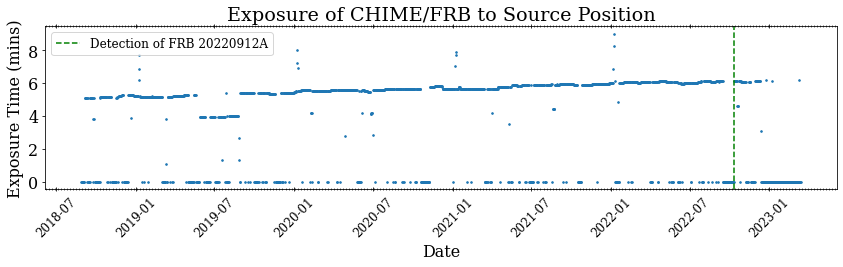

In [21]:
import matplotlib.dates as mdates
import matplotlib.lines as mlines

dates_split = [item[0] for item in dates_exposure]
exposure_split = [item[1] for item in dates_exposure]

# Increase the figure size
plt.figure(figsize=(12, 4))

# Plot the exposure time per day
plt.scatter(dates_split, exposure_split, marker=".", s=10, linewidths=1, alpha=1)
# Set the x-axis format as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Increase the number of ticks in between the x-axis labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(MultipleLocator(7))

# Add x-axis ticks on the top axis
ax.tick_params(axis='x', which='both', direction='inout', top=True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add a vertical line
line_date = datetime(2022, 10, 12).date()  # Convert line_date to a datetime.date object
plt.axvline(x=line_date, color='green', linestyle='--')

# Create a Line2D artist for the legend
legend_line = mlines.Line2D([], [], color='green', linestyle='--', label='Detection of FRB 20220912A')

# Add the legend
plt.legend(handles=[legend_line], loc='upper left', fontsize=12)


plt.xlabel('Date')
plt.ylabel('Exposure Time (mins)')
plt.title('Exposure of CHIME/FRB to Source Position')

plt.tight_layout()
plt.savefig('Exposure_to_source_position.pdf', bbox_inches='tight')
plt.show()



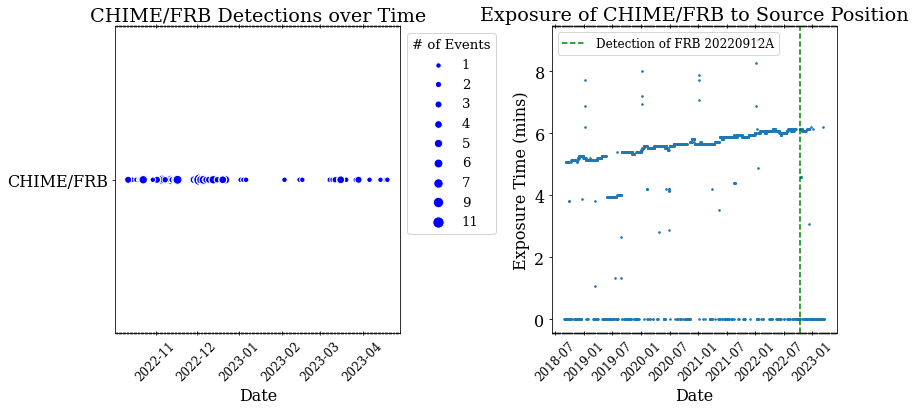

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from collections import Counter
from datetime import datetime

def plot_combined_panels(time_stamps, time_dates, dates_exposure):
    # Convert date objects to datetime objects
    time_stamps = [datetime.combine(date, datetime.min.time()) for date in time_dates]

    # Count the occurrences per day
    occurrences_per_day = Counter(time_stamps)

    # Get the sizes of markers based on occurrences
    marker_sizes = [20 + 10 * occurrences_per_day[ts] for ts in time_stamps]

    # Create a constant array for the y-axis
    y = [1] * len(time_dates)

    # Increase the figure size
    plt.figure(figsize=(12, 6))

    # Plot the timestamps on the x-axis and the constant on the y-axis with varying marker sizes
    plt.subplot(121)
    plt.scatter(time_stamps, y, s=marker_sizes, marker='o', facecolor='blue', edgecolor='white', alpha=1)

    # Set the x-axis format as dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Set the y-axis tick to 1
    plt.yticks([1], ['CHIME/FRB'])

    plt.xlabel('Date')
    plt.title('CHIME/FRB Detections over Time')

    # Increase the number of ticks in between the x-axis labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    # Add x-axis ticks on the top axis
    ax.tick_params(axis='x', which='both', direction='inout', top=True)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=12)

    # Add a legend for the size of markers
    sizes = [30, 40, 50, 60, 70, 80, 90, 110, 130]  # Replace with your actual size values
    legend_labels = ['1', '2', '3', '4', '5', '6', '7', '9', '11']  # Replace with your actual legend labels
    legend_markers = [plt.scatter([], [], s=size, marker='o', facecolor='blue', edgecolor='white', alpha=1) for size in sizes]
    legend = plt.legend(legend_markers, legend_labels, title='# of Events', loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
    legend.set_title('# of Events', prop={'size': 'small'})

    # Plot exposure time per day
    dates_split = [item[0] for item in dates_exposure]
    exposure_split = [item[1] for item in dates_exposure]

    plt.subplot(122)
    plt.scatter(dates_split, exposure_split, marker=".", s=10, linewidths=1, alpha=1)

    # Set the x-axis format as dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Increase the number of ticks in between the x-axis labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_minor_locator(MultipleLocator(7))

    # Add x-axis ticks on the top axis
    ax.tick_params(axis='x', which='both', direction='inout', top=True)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=12)

    # Add a vertical line
    line_date = datetime(2022, 10, 12).date()  # Convert line_date to a datetime.date object
    plt.axvline(x=line_date, color='green', linestyle='--')

    # Create a Line2D artist for the legend
    legend_line = mlines.Line2D([], [], color='green', linestyle='--', label='Detection of FRB 20220912A')

    # Add the legend
    plt.legend(handles=[legend_line], loc='upper left', fontsize=12)

    plt.xlabel('Date')
    plt.ylabel('Exposure Time (mins)')
    plt.title('Exposure of CHIME/FRB to Source Position')

    # Adjust the layout
    plt.tight_layout()

    # Save the plot before displaying
    plt.savefig('combined_panels.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function to plot the combined panels
plot_combined_panels(time_stamps, time_dates, dates_exposure)


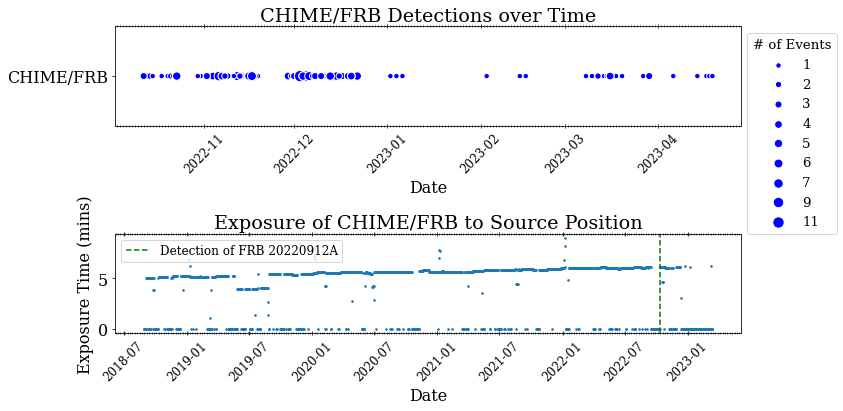

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from collections import Counter
from datetime import datetime

def plot_combined_panels(time_stamps, time_dates, dates_exposure):
    # Convert date objects to datetime objects
    time_stamps = [datetime.combine(date, datetime.min.time()) for date in time_dates]

    # Count the occurrences per day
    occurrences_per_day = Counter(time_stamps)

    # Get the sizes of markers based on occurrences
    marker_sizes = [20 + 10 * occurrences_per_day[ts] for ts in time_stamps]

    # Create a constant array for the y-axis
    y = [1] * len(time_dates)

    # Increase the figure size
    plt.figure(figsize=(12, 6))

    # Plot the timestamps on the x-axis and the constant on the y-axis with varying marker sizes
    plt.subplot(211)  # First subplot (top)
    plt.scatter(time_stamps, y, s=marker_sizes, marker='o', facecolor='blue', edgecolor='white', alpha=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set the x-axis format as dates
    plt.yticks([1], ['CHIME/FRB'])  # Set the y-axis tick to 1
    plt.xlabel('Date')
    plt.title('CHIME/FRB Detections over Time')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.tick_params(axis='x', which='both', direction='inout', top=True)  # Add x-axis ticks on the top axis
    plt.xticks(rotation=45, fontsize=12)  # Rotate the x-axis labels for better readability
    sizes = [30, 40, 50, 60, 70, 80, 90, 110, 130]  # Replace with your actual size values
    legend_labels = ['1', '2', '3', '4', '5', '6', '7', '9', '11']  # Replace with your actual legend labels
    legend_markers = [plt.scatter([], [], s=size, marker='o', facecolor='blue', edgecolor='white', alpha=1) for size in sizes]
    legend = plt.legend(legend_markers, legend_labels, title='# of Events', loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
    legend.set_title('# of Events', prop={'size': 'small'})

    # Plot exposure time per day
    dates_split = [item[0] for item in dates_exposure]
    exposure_split = [item[1] for item in dates_exposure]

    plt.subplot(212)  # Second subplot (bottom)
    plt.scatter(dates_split, exposure_split, marker=".", s=10, linewidths=1, alpha=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set the x-axis format as dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_minor_locator(MultipleLocator(7))
    ax.tick_params(axis='x', which='both', direction='inout', top=True)  # Add x-axis ticks on the top axis
    plt.xticks(rotation=45, fontsize=12)  # Rotate the x-axis labels for better readability
    line_date = datetime(2022, 10, 12).date()  # Convert line_date to a datetime.date object
    plt.axvline(x=line_date, color='green', linestyle='--')  # Add a vertical line
    legend_line = mlines.Line2D([], [], color='green', linestyle='--', label='Detection of FRB 20220912A')  # Create a Line2D artist for the legend
    plt.legend(handles=[legend_line], loc='upper left', fontsize=12)  # Add the legend
    plt.xlabel('Date')
    plt.ylabel('Exposure Time (mins)')
    plt.title('Exposure of CHIME/FRB to Source Position')

    # Adjust the layout
    plt.tight_layout()

    # Save the plot before displaying
    plt.savefig('combined_panels_2.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function to plot the combined panels
plot_combined_panels(time_stamps, time_dates, dates_exposure)


In [24]:
# Filter out dates from 'dates_exposure' that do not match with 'time_dates'
filtered_dates_exposure = [list(item) for item in dates_exposure if item[0] in time_dates]

In [25]:
# Create a dictionary for quick lookup of exposure times
exposure_dict = {date: exposure for date, exposure in filtered_dates_exposure}

# Create a new list with the corresponding exposure time
updated_time_dates_nonone = [(date, exposure_dict[date]) for date in time_dates if date in exposure_dict]


2.2 Recompute the Poisson rates for the total duration for which the source was active and for each
    day, now using the actual exposure of the instrument. Again, include Poisson error bars.

In [26]:
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

daily_rates_2 = []
unique_dates_2 = []  # Initialize a list to store unique dates
lower_bounds_2 = []  # Store lower bounds of confidence intervals
upper_bounds_2 = []  # Store upper bounds of confidence intervals

# Count occurrences of each date
date_counts = Counter(updated_time_dates_nonone)

# Loop through the unique dates
for date in date_counts.keys():
    # Get the count for the current date
    count_2 = date_counts[date]
    exposure_time = date[1]  # Extract the exposure time from the tuple
    
    # Skip dates with zero exposure time
    if exposure_time == 0:
        continue
    
    # Calculate the rate in detections per day using the exposure time
    daily_rate_2 = count_2 / exposure_time
    daily_rates_2.append(daily_rate_2)
    
    unique_dates_2.append(date)  # Append the unique date to the list
    
    print(f"\n{date[0]} Burst Rate:")
    print(f"Number of Detections: {count_2}")
    print(f"Burst Rate per day: {daily_rate_2} bursts/min")
    
    # Calculate Poisson error bars on daily rate
    confidence = 0.9  # 90% confidence interval
    lower_bound_daily_2, upper_bound_daily_2 = poisson.interval(confidence, count_2, loc=0)
    lower_bound_daily_2 /= exposure_time  # Adjust the lower bound to per day rate
    upper_bound_daily_2 /= exposure_time  # Adjust the upper bound to per day rate
    lower_bounds_2.append(lower_bound_daily_2)
    upper_bounds_2.append(upper_bound_daily_2)  
    print(f"Confidence Interval on burst rate per min: [{lower_bound_daily_2}, {upper_bound_daily_2}]")
    
    dates_only_2 = [date[0] for date in unique_dates_2]


# Calculate burst rate for the total duration
total_detections_2 = sum(count_2 for date, count_2 in date_counts.items() if date[1] != 0)
total_exposure_time_2 = sum(date[1] for date in date_counts.keys())
total_rate_2 = total_detections_2 / total_exposure_time_2

confidence = 0.9
lower_bound_2, upper_bound_2 = poisson.interval(confidence, total_rate_2)
print(f"\nTotal Burst Rate:")
print(f"Total Detections: {total_detections_2}")
print(f"Total Duration: {total_exposure_time_2}")
print(f"Burst Rate: {total_rate_2} bursts/min")
print(f"Confidence Interval on total burst rate: [{lower_bound_2/total_exposure_time_2}, {upper_bound_2/total_exposure_time_2}]")

##This is only the total burst rate for those within the fwhm or with non-zero exposure time




2023-03-11 Burst Rate:
Number of Detections: 1
Burst Rate per day: 0.16129032258064516 bursts/min
Confidence Interval on burst rate per min: [0.0, 0.48387096774193544]

2022-12-03 Burst Rate:
Number of Detections: 11
Burst Rate per day: 1.7934782608695652 bursts/min
Confidence Interval on burst rate per min: [0.9782608695652173, 2.7717391304347823]

2022-12-05 Burst Rate:
Number of Detections: 9
Burst Rate per day: 1.467391304347826 bursts/min
Confidence Interval on burst rate per min: [0.6521739130434783, 2.282608695652174]

2022-12-06 Burst Rate:
Number of Detections: 6
Burst Rate per day: 0.9782608695652173 bursts/min
Confidence Interval on burst rate per min: [0.32608695652173914, 1.6304347826086956]

2022-12-04 Burst Rate:
Number of Detections: 5
Burst Rate per day: 0.8152173913043478 bursts/min
Confidence Interval on burst rate per min: [0.32608695652173914, 1.467391304347826]

2022-12-08 Burst Rate:
Number of Detections: 3
Burst Rate per day: 0.48913043478260865 bursts/min
Conf

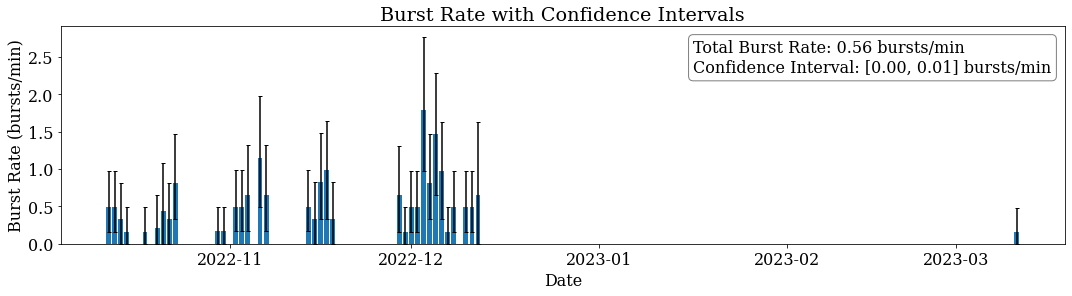

In [27]:
# Plotting
plt.figure(figsize=(18, 4))
x_2 = np.array(dates_only_2)
y_2 = np.array(daily_rates_2)
y_error_2 = np.array([y_2 - lower_bounds_2, upper_bounds_2 - y_2])

plt.bar(x_2, y_2, yerr=y_error_2, capsize=2)

plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rate with Confidence Intervals')

# Create a box in the top right corner with mean burst rate and confidence interval information
text_box = f"Total Burst Rate: {total_rate_2:.2f} bursts/min\n"
text_box += f"Confidence Interval: [{lower_bound_2/total_exposure_time_2:.2f}, {upper_bound_2/total_exposure_time_2:.2f}] bursts/min"


plt.text(0.63, 0.79, text_box, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Burst_Rates_with_Confidence_Intervals_2.pdf', bbox_inches='tight')
plt.show()


In [28]:
# Stack the unique_dates and daily_rates arrays
stacked_data_2 = np.column_stack((dates_only_2, daily_rates_2))

# Sort the stacked data by date
sorted_data_2 = stacked_data_2[np.argsort(stacked_data_2[:, 0])]

# Extract the sorted unique_dates and daily_rates arrays
sorted_dates_2 = sorted_data_2[:, 0]
sorted_rates_2 = sorted_data_2[:, 1]

# Convert sorted_dates to matplotlib.dates.date2num format
sorted_dates_2 = mdates.date2num(sorted_dates_2)

sorted_dates_2 = sorted_dates_2.astype(float)
sorted_rates_2 = sorted_rates_2.astype(float)

# # Create a step plot
# plt.figure(figsize=(12, 4))

# plt.fill_between(sorted_dates_2, sorted_rates_2, color='red', step='pre', alpha=0.2)
# plt.plot(sorted_dates_2, sorted_rates_2, color='red', drawstyle="steps", marker='|')


# # Set the x-axis label and rotate the x-axis tick labels for better readability
# plt.xlabel('Date')
# plt.ylabel('Burst Rate (bursts/min)')
# plt.title('Burst Rates over Time')

# # Format the x-axis tick labels as "YYYY-MM"
# date_formatter = mdates.DateFormatter('%Y-%m')
# plt.gca().xaxis.set_major_formatter(date_formatter)

# # Rotate the x-axis labels for better readability
# plt.xticks(rotation=45, fontsize=12)

# plt.tight_layout()
# #plt.savefig('Burst_rates_2_over_time.pdf')
# # Display the plot
# plt.show()

In [29]:
rate_list_2 = []

for date in time_dates:
    matching_row_2 = np.where(sorted_data_2[:, 0] == date)[0]
    if len(matching_row_2) > 0:
        rate_2 = sorted_data_2[matching_row_2[0], 1]
        rate_list_2.append([date, rate_2])
    else:
        rate_list_2.append([date, None])

len(rate_list_2)

# Convert rate_list to a NumPy array
rate_list_2 = np.array(rate_list_2)
# Sort the stacked data by date
sorted_rate_list_2 = rate_list_2[np.argsort(rate_list_2[:, 0])]

# Extract the sorted arrays seperately
sorted_rate_list_date_2 = sorted_rate_list_2[:, 0]
sorted_rate_list_rate_2 = sorted_rate_list_2[:, 1]

# Convert sorted_dates to matplotlib.dates.date2num format
sorted_rate_list_date_2 = mdates.date2num(sorted_rate_list_date_2)

sorted_rate_list_date_2 = sorted_rate_list_date_2.astype(float)
sorted_rate_list_rate_2 = sorted_rate_list_rate_2.astype(float)


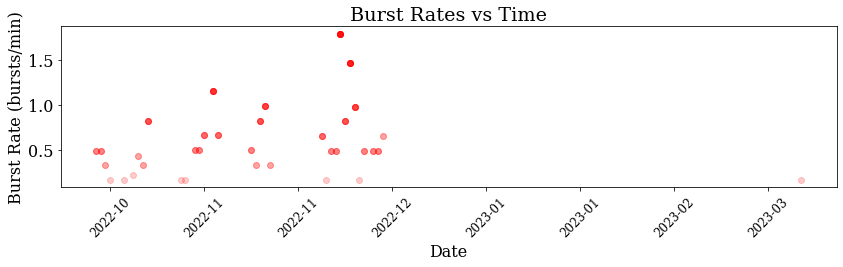

In [30]:
# Create a scatter plot
plt.figure(figsize=(12, 4))

plt.scatter(sorted_rate_list_date_2, sorted_rate_list_rate_2, color='red', alpha=0.2)


# Set the x-axis label and rotate the x-axis tick labels for better readability
plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rates vs Time')

# Format the x-axis tick labels as "YYYY-MM"
date_formatter = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_formatter)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

plt.tight_layout()
plt.savefig('Burst_Rates_over_Time_2.pdf', bbox_inches='tight')
# Display the plot
plt.show()

# It seems the sensitivity of the telescope decreased significantly during 2022-12 to 2023-03 most likely due to
# snow on CHIME
# More opaque+more ovservations at that date +burst rate

Extra stuff (for my own reference):

In [31]:
time_dates

[datetime.date(2023, 2, 14),
 datetime.date(2023, 2, 16),
 datetime.date(2023, 3, 8),
 datetime.date(2023, 3, 11),
 datetime.date(2023, 3, 12),
 datetime.date(2023, 3, 14),
 datetime.date(2023, 3, 16),
 datetime.date(2023, 3, 17),
 datetime.date(2023, 3, 18),
 datetime.date(2023, 3, 20),
 datetime.date(2023, 3, 29),
 datetime.date(2023, 3, 29),
 datetime.date(2023, 4, 6),
 datetime.date(2023, 4, 17),
 datetime.date(2023, 4, 14),
 datetime.date(2023, 4, 18),
 datetime.date(2023, 4, 19),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 1, 4),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 2, 3),
 datetime.date(2023, 3, 10),
 datetime.date(2023, 3, 12),
 datetime.date(2023, 3, 15),
 datetime.date(2023, 3, 16),
 datetime.date(2023, 3, 16),
 datetime.date(2023, 3, 16),
 datetime.date(2023, 3, 27),
 datetime.date(2023, 3, 29),
 datetime.date(2022, 12, 3),
 datetime.date(2022, 12, 3),
 datetime.date(2022, 12, 3),
 datetime.date(2022, 12, 5),
 datetime.date(2022, 12, 6),
 datetime.date(2022,

In [32]:
dates_exposure

array([[datetime.date(2018, 8, 28), 0.0],
       [datetime.date(2018, 8, 29), 0.0],
       [datetime.date(2018, 8, 30), 0.0],
       [datetime.date(2018, 8, 31), 0.0],
       [datetime.date(2018, 9, 1), 0.0],
       [datetime.date(2018, 9, 2), 0.0],
       [datetime.date(2018, 9, 3), 0.0],
       [datetime.date(2018, 9, 4), 0.0],
       [datetime.date(2018, 9, 5), 5.066666666666666],
       [datetime.date(2018, 9, 6), 5.066666666666666],
       [datetime.date(2018, 9, 7), 5.066666666666666],
       [datetime.date(2018, 9, 8), 5.066666666666666],
       [datetime.date(2018, 9, 9), 5.066666666666666],
       [datetime.date(2018, 9, 10), 5.066666666666666],
       [datetime.date(2018, 9, 11), 0.0],
       [datetime.date(2018, 9, 12), 5.066666666666666],
       [datetime.date(2018, 9, 13), 0.0],
       [datetime.date(2018, 9, 14), 0.0],
       [datetime.date(2018, 9, 15), 0.0],
       [datetime.date(2018, 9, 16), 5.066666666666666],
       [datetime.date(2018, 9, 17), 5.066666666666666],
 

In [33]:
# Dates that have bursts but no exposure
no_exposure = [(date, exposure) for date, exposure in dates_exposure if exposure == 0.0 and date in time_dates]

print(no_exposure)

##From 2022-12-13 to 2022-12-22 There are consistently bursts at 0 exposure... detecting in sidelobes??? 
#Would have to confirm this with part 3


[(datetime.date(2022, 11, 8), 0.0), (datetime.date(2022, 11, 9), 0.0), (datetime.date(2022, 11, 11), 0.0), (datetime.date(2022, 11, 12), 0.0), (datetime.date(2022, 11, 13), 0.0), (datetime.date(2022, 11, 19), 0.0), (datetime.date(2022, 12, 13), 0.0), (datetime.date(2022, 12, 14), 0.0), (datetime.date(2022, 12, 15), 0.0), (datetime.date(2022, 12, 16), 0.0), (datetime.date(2022, 12, 17), 0.0), (datetime.date(2022, 12, 18), 0.0), (datetime.date(2022, 12, 19), 0.0), (datetime.date(2022, 12, 20), 0.0), (datetime.date(2022, 12, 21), 0.0), (datetime.date(2022, 12, 22), 0.0), (datetime.date(2023, 1, 2), 0.0), (datetime.date(2023, 1, 4), 0.0), (datetime.date(2023, 1, 6), 0.0), (datetime.date(2023, 2, 3), 0.0), (datetime.date(2023, 2, 14), 0.0), (datetime.date(2023, 2, 16), 0.0), (datetime.date(2023, 3, 8), 0.0), (datetime.date(2023, 3, 10), 0.0), (datetime.date(2023, 3, 12), 0.0), (datetime.date(2023, 3, 14), 0.0)]


In [34]:
# Dates that have no bursts but have exposure... burst rate should be 0 with confidence interval upper bound as 0 too.. right?

no_bursts_yes_exposure = []

for date, exposure in dates_exposure:
    if date not in time_dates:
        no_bursts_yes_exposure.append(date)

print(no_bursts_yes_exposure)




[datetime.date(2018, 8, 28), datetime.date(2018, 8, 29), datetime.date(2018, 8, 30), datetime.date(2018, 8, 31), datetime.date(2018, 9, 1), datetime.date(2018, 9, 2), datetime.date(2018, 9, 3), datetime.date(2018, 9, 4), datetime.date(2018, 9, 5), datetime.date(2018, 9, 6), datetime.date(2018, 9, 7), datetime.date(2018, 9, 8), datetime.date(2018, 9, 9), datetime.date(2018, 9, 10), datetime.date(2018, 9, 11), datetime.date(2018, 9, 12), datetime.date(2018, 9, 13), datetime.date(2018, 9, 14), datetime.date(2018, 9, 15), datetime.date(2018, 9, 16), datetime.date(2018, 9, 17), datetime.date(2018, 9, 18), datetime.date(2018, 9, 19), datetime.date(2018, 9, 20), datetime.date(2018, 9, 21), datetime.date(2018, 9, 22), datetime.date(2018, 9, 23), datetime.date(2018, 9, 24), datetime.date(2018, 9, 25), datetime.date(2018, 9, 26), datetime.date(2018, 9, 27), datetime.date(2018, 9, 28), datetime.date(2018, 9, 29), datetime.date(2018, 9, 30), datetime.date(2018, 10, 1), datetime.date(2018, 10, 2), 

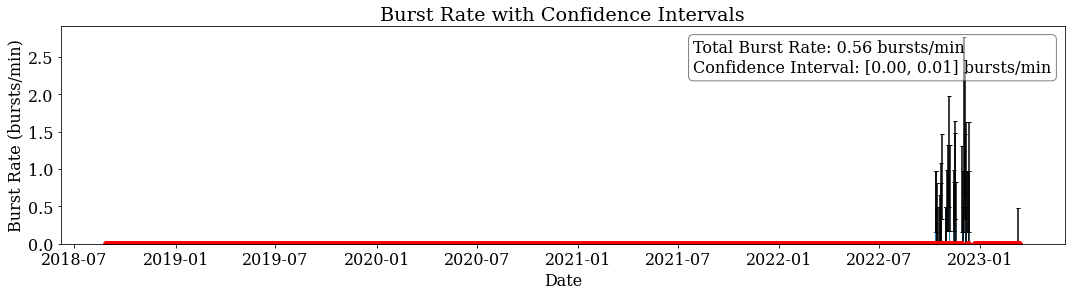

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
plt.figure(figsize=(18, 4))
x_2 = np.array(dates_only_2)
y_2 = np.array(daily_rates_2)
y_error_2 = np.array([y_2 - lower_bounds_2, upper_bounds_2 - y_2])

plt.bar(x_2, y_2, yerr=y_error_2, capsize=2)

# Plotting dots for dates with no bursts
no_burst_dates = []
no_burst_values = []

for date in no_bursts_yes_exposure:
    no_burst_dates.append(date)
    no_burst_values.append(0)

plt.plot(no_burst_dates, no_burst_values, 'ro', label='No Bursts')

plt.xlabel('Date')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rate with Confidence Intervals')

# Create a box in the top right corner with mean burst rate and confidence interval information
text_box = f"Total Burst Rate: {total_rate_2:.2f} bursts/min\n"
text_box += f"Confidence Interval: [{lower_bound_2/total_exposure_time_2:.2f}, {upper_bound_2/total_exposure_time_2:.2f}] bursts/min"

plt.text(0.63, 0.79, text_box, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
#plt.savefig('Burst_Rates_with_Confidence_Intervals_2.pdf', bbox_inches='tight')
plt.show()


In [36]:
import datetime

no_bursts_yes_exposure.sort()  # Sort the dates in ascending order

gap_start = None
gap_end = None
max_gap = datetime.timedelta(days=0)  # Initialize maximum gap duration as 0 days

for i in range(len(no_bursts_yes_exposure) - 1):
    current_date = no_bursts_yes_exposure[i]
    next_date = no_bursts_yes_exposure[i + 1]
    gap_duration = next_date - current_date

    if gap_duration > max_gap:
        max_gap = gap_duration
        gap_start = current_date
        gap_end = next_date

print("Longest gap in dates:")
print("Start:", gap_start)
print("End:", gap_end)
print("Duration:", max_gap)

#This gap is when the confidence interval upper limit would be 0

#I don't understand. If the telescope's exposure is definied by the transit in FWHM how are we detecting 
#no bursts and yet the exposure is non-zero.. especially when this is when the first detection was supposed to be
#How can a source be considered in the FWHM of the beam and yet not be detected?

###WAIT this section of time is within the section of time where we see the bursts in the sidelobes.. 
#Maybe we don't detect it becausethe sensitivity of the telescope is decreased due to the snow but we know its there
#since we know what period we are detecting bursts in the sidelobes?..


Longest gap in dates:
Start: 2022-12-09
End: 2022-12-23
Duration: 14 days, 0:00:00


In [37]:
import datetime

no_bursts_yes_exposure.sort()  # Sort the dates in ascending order

gaps = []  # List to store the gaps

for i in range(len(no_bursts_yes_exposure) - 1):
    current_date = no_bursts_yes_exposure[i]
    next_date = no_bursts_yes_exposure[i + 1]
    gap_duration = next_date - current_date

    if gap_duration > datetime.timedelta(days=2):
        gaps.append((current_date, next_date, gap_duration))

# Print all the gaps above 2 days
print("Gaps in dates above 2 days:")
for gap_start, gap_end, gap_duration in gaps:
    print("Start:", gap_start)
    print("End:", gap_end)
    print("Duration:", gap_duration)
    print("---")



Gaps in dates above 2 days:
Start: 2022-10-11
End: 2022-10-16
Duration: 5 days, 0:00:00
---
Start: 2022-10-19
End: 2022-10-24
Duration: 5 days, 0:00:00
---
Start: 2022-10-29
End: 2022-11-01
Duration: 3 days, 0:00:00
---
Start: 2022-11-01
End: 2022-11-05
Duration: 4 days, 0:00:00
---
Start: 2022-11-05
End: 2022-11-10
Duration: 5 days, 0:00:00
---
Start: 2022-11-10
End: 2022-11-20
Duration: 10 days, 0:00:00
---
Start: 2022-11-28
End: 2022-12-09
Duration: 11 days, 0:00:00
---
Start: 2022-12-09
End: 2022-12-23
Duration: 14 days, 0:00:00
---
Start: 2023-03-09
End: 2023-03-13
Duration: 4 days, 0:00:00
---


In [38]:
#Sticking rates and bursts together
rates_exp = [(daily_rates_2[i], unique_dates_2[i][1]) for i in range(len(unique_dates_2))]

#Extracting rates from bursts
rates = [item[0] for item in rates_exp]
bursts = [item[1] for item in rates_exp]

rates_exp

[(0.16129032258064516, 6.2),
 (1.7934782608695652, 6.133333333333334),
 (1.467391304347826, 6.133333333333334),
 (0.9782608695652173, 6.133333333333334),
 (0.8152173913043478, 6.133333333333334),
 (0.48913043478260865, 6.133333333333334),
 (0.48913043478260865, 6.133333333333334),
 (0.6521739130434783, 6.133333333333334),
 (0.6593406593406593, 6.066666666666666),
 (0.8241758241758242, 6.066666666666666),
 (0.6521739130434783, 3.066666666666667),
 (0.4945054945054945, 6.066666666666666),
 (1.153846153846154, 6.066666666666666),
 (0.6593406593406593, 6.066666666666666),
 (0.4945054945054945, 6.066666666666666),
 (0.32967032967032966, 6.066666666666666),
 (0.989010989010989, 6.066666666666666),
 (0.32967032967032966, 6.066666666666666),
 (0.48913043478260865, 6.133333333333334),
 (0.48913043478260865, 6.133333333333334),
 (0.48913043478260865, 6.133333333333334),
 (0.4945054945054945, 6.066666666666666),
 (0.16304347826086957, 6.133333333333334),
 (0.16304347826086957, 6.133333333333334),

In [39]:
# Sort the stacked data by date
sorted_rate_list_2 = rate_list_2[np.argsort(rate_list_2[:, 0])]

# Extract the sorted unique_dates and daily_rates arrays
sorted_rate_list_date_2 = sorted_rate_list_2[:, 0]
sorted_rate_list_rate_2 = sorted_rate_list_2[:, 1]

# Convert sorted_dates to matplotlib.dates.date2num format
sorted_rate_list_date_2 = mdates.date2num(sorted_rate_list_date_2)

sorted_rate_list_date_2 = sorted_rate_list_date_2.astype(float)
sorted_rate_list_rate_2 = sorted_rate_list_rate_2.astype(float)

In [40]:
sorted_rate_list_rate_2

array([0.48913043, 0.48913043, 0.48913043, 0.48913043, 0.48913043,
       0.48913043, 0.32608696, 0.32608696, 0.16304348, 0.16304348,
       0.2173913 , 0.43478261, 0.43478261, 0.32608696, 0.32608696,
       0.81521739, 0.81521739, 0.81521739, 0.81521739, 0.81521739,
       0.16483516, 0.16483516, 0.49450549, 0.49450549, 0.49450549,
       0.49450549, 0.49450549, 0.49450549, 0.65934066, 0.65934066,
       0.65934066, 0.65934066, 1.15384615, 1.15384615, 1.15384615,
       1.15384615, 1.15384615, 1.15384615, 1.15384615, 0.65934066,
       0.65934066, 0.65934066, 0.65934066,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.49450549, 0.49450549, 0.49450549, 0.32967033,
       0.32967033, 0.82417582, 0.82417582, 0.82417582, 0.82417582,
       0.82417582, 0.98901099, 0.98901099, 0.98901099, 0.98901099,
       0.98901099, 0.98901099, 0.32967033, 0.32967033,        

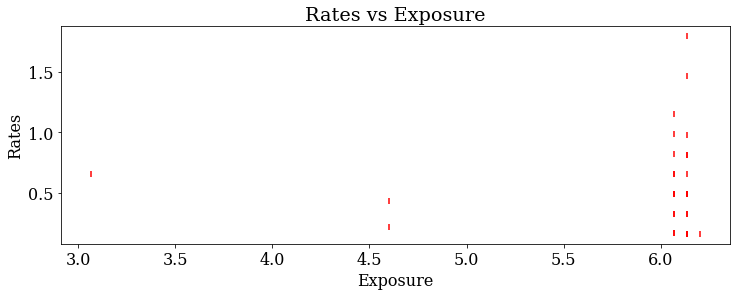

In [41]:
import matplotlib.pyplot as plt

# Sticking rates and bursts together
rates_exp = [(daily_rates_2[i], unique_dates_2[i][1]) for i in range(len(unique_dates_2))]

# Extracting rates from bursts
rates = [item[0] for item in rates_exp]
exp = [item[1] for item in rates_exp]

# Create a scatter plot
plt.figure(figsize=(12, 4))
plt.scatter(exp, rates, color='red', marker='|')

# Set the x-axis and y-axis labels
plt.xlabel('Exposure')
plt.ylabel('Rates')

# Set the title of the plot
plt.title('Rates vs Exposure')

# Show the plot
plt.show()


In [42]:
bursts


[6.2,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.066666666666666,
 6.066666666666666,
 3.066666666666667,
 6.066666666666666,
 6.066666666666666,
 6.066666666666666,
 6.066666666666666,
 6.066666666666666,
 6.066666666666666,
 6.066666666666666,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.066666666666666,
 6.133333333333334,
 6.133333333333334,
 6.066666666666666,
 6.066666666666666,
 6.133333333333334,
 4.6,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 6.133333333333334,
 4.6]

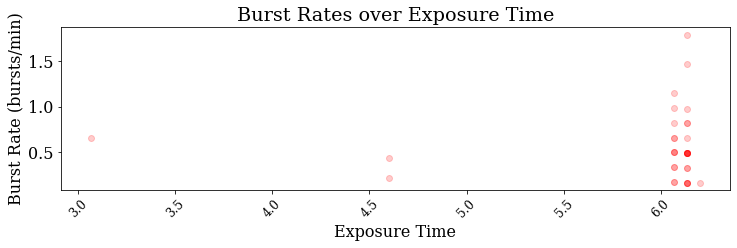

In [43]:
# Create a step plot
plt.figure(figsize=(12, 3))

plt.scatter(bursts, rates, color='red', alpha=0.2)
#plt.scatte(bursts, rates, color='red', drawstyle="steps", marker='|')


# Set the x-axis label and rotate the x-axis tick labels for better readability
plt.xlabel('Exposure Time')
plt.ylabel('Burst Rate (bursts/min)')
plt.title('Burst Rates over Exposure Time')


# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

plt.savefig('Burst_rates_2_over_time.png')
# Display the plot
plt.show()

# Opacity of points denotes # of burst rates at that exposure